<a href="https://colab.research.google.com/github/LimJongYoon/2020MLP/blob/master/18_ML_lesson7_superres_gan_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pretrained GAN

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image, ImageDraw, ImageFont

In [0]:
!pip install "torch==1.4" "torchvision==0.5.0" 
#The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, 
#instead of relying on the computed output size. 
#If you wish to keep the old behavior, please set recompute_scale_factor=True. 
#See the documentation of nn.Upsample for details. warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "에러남 

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 47.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [0]:
class crappifier(object):  
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)  #이미지오픈
        targ_sz = resize_to(img, 50, use_min=True) #이중선형 보간법으로 96*96으로 조정
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,400) #10에서 70사이수 랜덤
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)#JPEG으로 저장

## Crappified data

Prepare the input data by crappifying images.

In [0]:
#from crappify import *

Uncomment the first time you run this notebook.

In [0]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items) #모든 함수를 병렬로 실행하게 하는거

For gradual resizing we can change the commented line here.

In [0]:
#bs,size=32, 128
#bs,size = 24,160
bs,size = 8,256 # 컴퓨터가 64비트라서 이거로 해줘야하나봄
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [0]:
arch = models.resnet34 #정규화
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

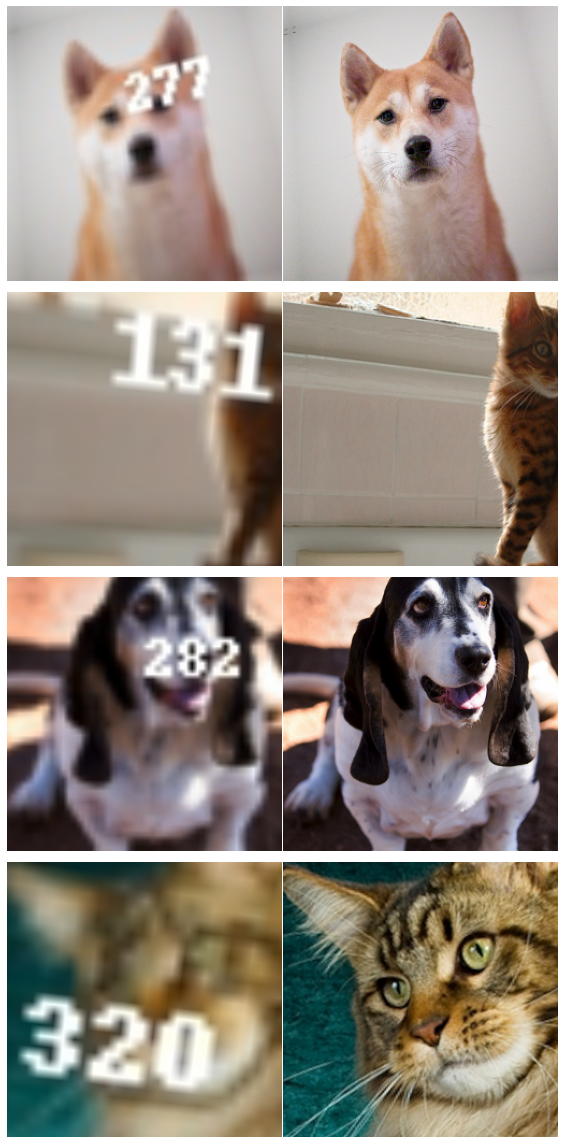

In [0]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat() #MSE손실이 픽셀값 평균 제곱 오차라는 거라는데..

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)  #blur, num_type_self_attention이 생성될예정

In [0]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn_gen.fit_one_cycle(2, pct_start=0.8)  ## 오류 수정해서 다시했는데 잘돌아가는데 오류메세지는 계속 그대로남음 ...

epoch,train_loss,valid_loss,time
0,0.114153,0.105887,06:32
1,0.098556,0.088500,06:24


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
learn_gen.unfreeze()

In [0]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.092002,0.087049,06:52
1,0.093242,0.082579,06:51
2,0.087207,0.080752,06:52


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

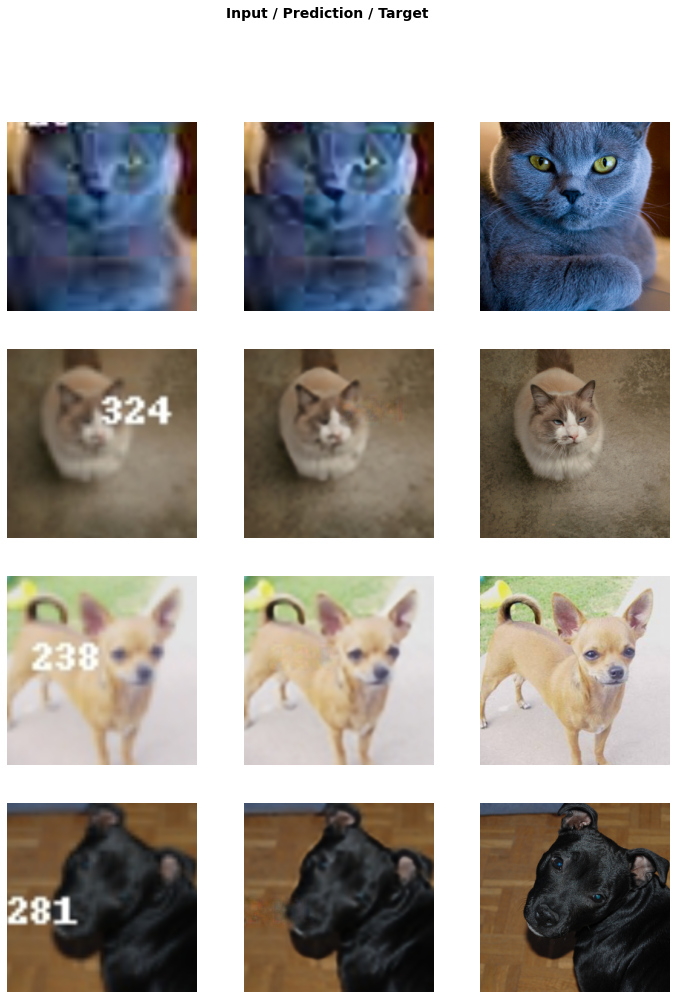

In [0]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-pre2')

## Save generated images

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
# shutil.rmtree(path_gen)

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl): #불러와서 각 픽셀 배치에 대한 예측후 그 픽셀을 생성시키는것?
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

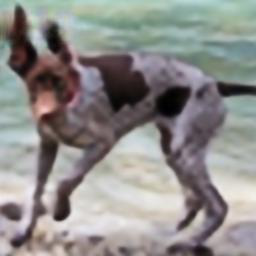

In [0]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [0]:
learn_gen=None
gc.collect()

114

Pretrain the critic on crappy vs not crappy.

In [0]:
def get_crit_data(classes, bs, size): #확인하는것 우리가 만든 세트가 얼마나 잘 작동하고있는지 무작위 분할로 확인하는것
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

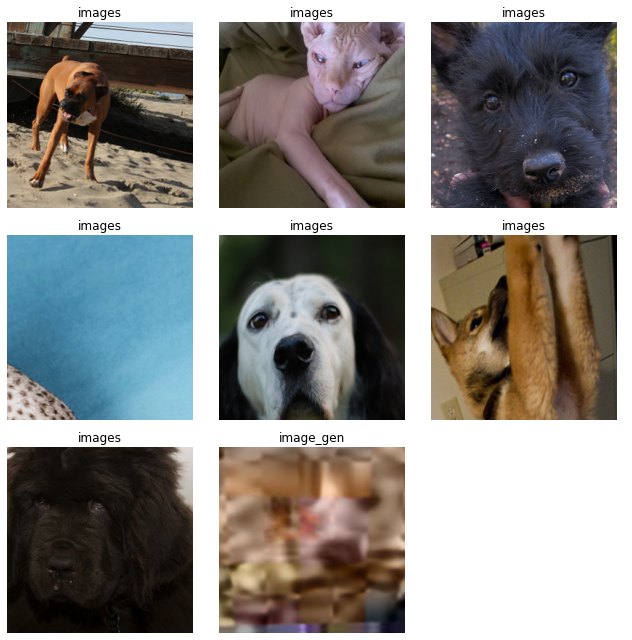

In [0]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3) #여기서 나오는건 실제이미지

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):#이진교차엔트로피를 사용
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd) 

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [0]:
learn_critic.fit_one_cycle(6, 1e-3) #해당오류를 없애려면 배치사이즈를 줄여야하는데 배치사이즈를 줄이면 제일 위에서 오류가남
#추가 - 파이참으로는 돌아감 

In [0]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [0]:
learn_crit=None
learn_gen=None
gc.collect() 

18846

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [0]:
learn.fit(40,lr)

In [0]:
learn.save('gan-1c')

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(10,lr/2)

In [0]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')

## fin